# Greedy Search Algorithm

In [1]:
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, Lasso, ElasticNet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.feature_selection import RFE
from genetic_selection import GeneticSelectionCV

Theil's U test for prediction accuracy

In [2]:
def TheilU(pred, true):
    s1 = 0
    s2 = 0
    s3 = 0
    n = len(true)-1
    for i in range(0,n-1):
        if pred[i+1]-true[i] > 0:
            if true[i+1] - true[i] > 0:
                s1+= 1
        else:
            if true[i+1] - true[i] < 0:
                s1+= 1

        s2 += ((pred[i+1]-true[i])-(true[i+1]-true[i]))**2
        s3 += (true[i+1]-true[i])**2
    mda = s1/n
    U2 = math.sqrt((s2)/(s3))

    return mda, U2

# Target variable is next day price of WTI Crude Oil Future

In [3]:
df = pd.read_csv("Features.csv")
df['Date'] = pd.to_datetime(df['Date'])
features = df.columns[1:]

In [38]:
y = np.asarray(df['Price'][:-1])
no_change = np.asarray(df['Price'].shift(-1).dropna())
mspe = mean_squared_error(y[-500:], no_change[-500:])
r2 = r2_score(y[-500:], no_change[-500:])
    
print("r2(pred): ", r2)
print("MSPE:", mspe)
print("MDA: ", TheilU(y, no_change)[0])
print("Theil's U2 (Accuracy): ", TheilU(y, no_change)[1])

r2(pred):  0.9675954375459839
MSPE: 1.3932797999999993
MDA:  0.4805352798053528
Theil's U2 (Accuracy):  1.0


### Split the data into training and testing (len=500) dataset

In [4]:
X = df[features][:-1]
y = df['Price'].shift(-1).dropna()

trainX = X[:-500]
trainy = y[:-500]
testX = X[-500:]
testy = y[-500:]

# Function for the Out-of-Sample forecasting (Linear Regression)

In [5]:
def forecasting(trainX, trainy, testX, testy, method):
    testX = np.asarray(testX)
    testy = np.asarray(testy)
    historyX = np.asarray(trainX)
    historyY = np.asarray(trainy)
    
    prediction = list()
    for i in range(len(testy)):
        
        #normalize X
        sc = MinMaxScaler()
        trainX_scaled = sc.fit_transform(historyX)
        testX_scaled = sc.transform(testX)
        
        #normalize y
        sc_y = MinMaxScaler()
        trainy_scaled = sc_y.fit_transform(historyY.reshape(-1,1))
        
        #predict the next target value
        model = LinearRegression().fit(trainX_scaled, trainy_scaled)
        y_pred = sc_y.inverse_transform(model.predict(testX_scaled[i].reshape(1,-1)))[0][0]
        
        prediction.append(y_pred)
        
        if method == 'moving':
            historyX = np.append(historyX[1:], testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY[1:], testy[i])
        elif method == "growing":
            historyX = np.append(historyX, testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY, testy[i])
        
    return prediction

def forecast(trainX, trainy, testX, testy, method):
    p = forecasting(trainX, trainy, testX, testy, method)
    mspe = mean_squared_error(testy, p)
    r2 = r2_score(testy, p)
    print("r2(pred): ", r2)
    print("MSPE:", mspe)
    print("MDA: ", TheilU(p, testy.values)[0])
    print("Theil's U2 (Accuracy): ", TheilU(p, testy.values)[1])
    plt.figure(figsize=(16,8))
    plt.plot(df['Date'][-500:], testy)
    plt.plot(df['Date'][-500:], p)
    plt.show()
    return mspe, r2

# Forward Selection

In [6]:
def forward(X, y):
    trainX = X[:-400]
    trainy = y[:-400]
    valX = X[-400:]
    valy = y[-400:]
    
    features = trainX.columns.tolist()
    adjusted_r = 0
    X = trainX['Price']
    lr = LinearRegression().fit(X.values.reshape(-1,1), trainy)
    score = lr.score(valX['Price'].values.reshape(-1,1), valy)
    adjusted_r = 1-((1-score)*(len(X)-1)/(len(X)-1-1))
    
    features.remove('Price')
    selected = ['Price']
    while True:
        old = len(selected)
        old_feature = 'Price'
        new_feature = 'Price'
        for f in features:
            X = trainX[selected+[f]]
            valx = valX[selected+[f]]
            lr = LinearRegression().fit(X, trainy)
            score = lr.score(valx, valy) 
            new_adjusted_r = 1-((1-score)*(len(X)-1)/(len(X)-(len(selected)+1)-1))
            if new_adjusted_r > adjusted_r:
                adjusted_r = new_adjusted_r
                new_feature = f
        if new_feature == old_feature:
            break
        else:
            selected.append(new_feature)
            features.remove(new_feature)
            
    return selected

All variables

In [7]:
selected = forward(trainX, trainy)
print(selected)

['Price', 'MA(5)', 'MA(10)', 'Kilian', 'Heating Oil']


Technical Only

In [8]:
X_2 = X.drop(columns=['Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production'])
trainX_2 = X_2[:-500]
testX_2 = X_2[-500:]
selected_2 = forward(trainX_2, trainy)
print(selected_2)

['Price', 'MA(5)', 'MA(10)']


Macroeconomic Only

In [9]:
X_3 = X[['Price','Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production']]
trainX_3 = X_3[:-500]
testX_3 = X_3[-500:]
selected_3 = forward(trainX_3, trainy)
print(selected_3)

['Price', 'Kilian', 'Heating Oil']


## Out of sample forecasting with moving window method

r2(pred):  0.9677168418771447
MSPE: 1.3874906351066192
MDA:  0.533066132264529
Theil's U2 (Accuracy):  0.9979289627909077


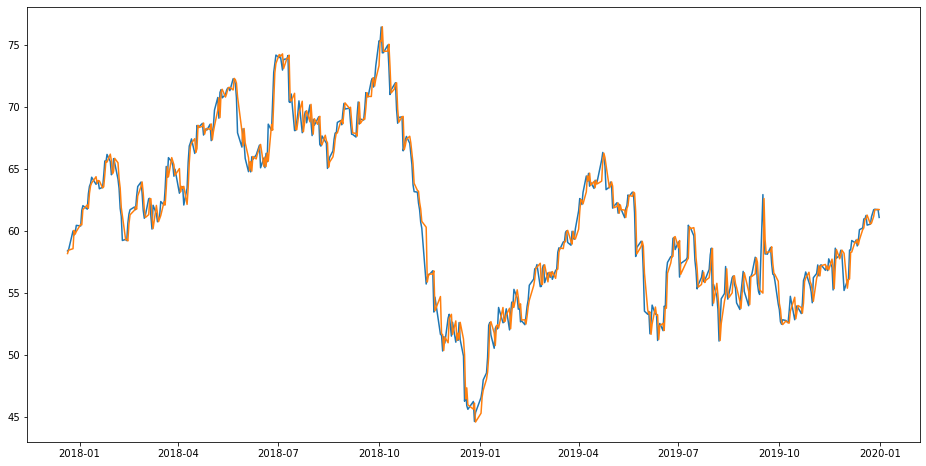

r2(pred):  0.9678474763999746
MSPE: 1.381876123157128
MDA:  0.5230460921843687
Theil's U2 (Accuracy):  0.9959020302440894


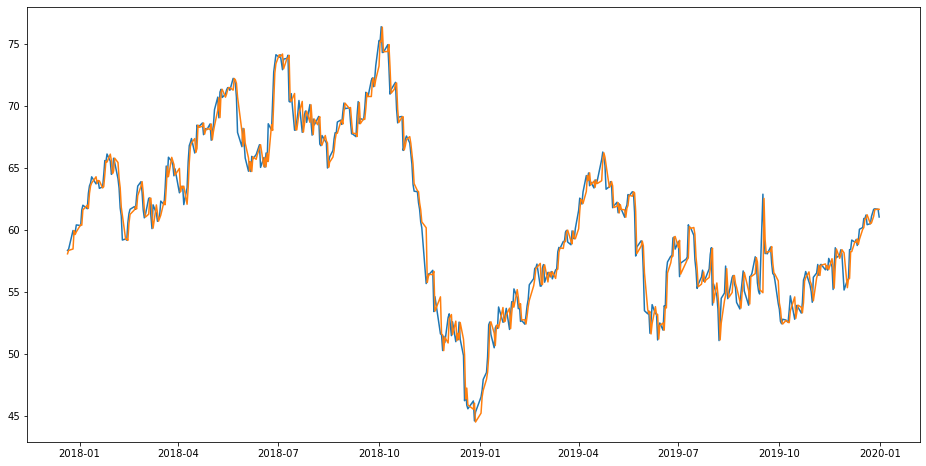

r2(pred):  0.9674773500264771
MSPE: 1.3977837018109722
MDA:  0.5430861723446894
Theil's U2 (Accuracy):  1.0016298605534983


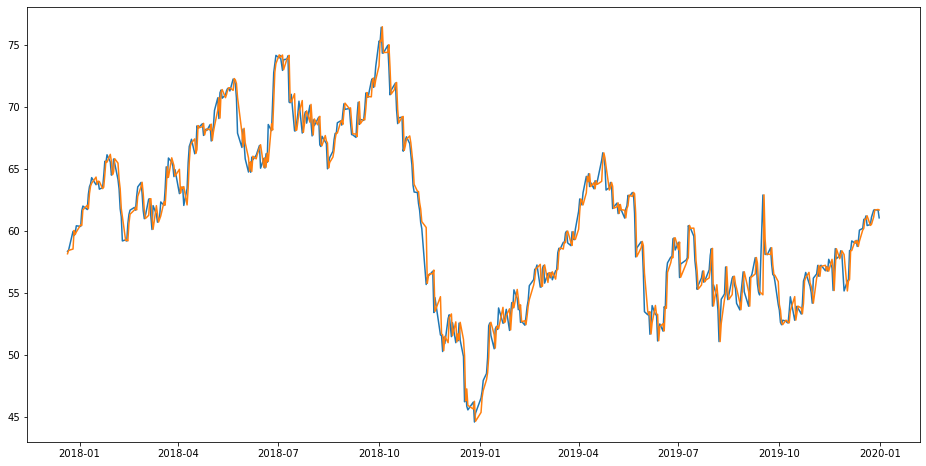

In [10]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'moving')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'moving')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'moving')

## Out of sample forecasting with growing window method

r2(pred):  0.9676355028304947
MSPE: 1.3909864878068345
MDA:  0.5430861723446894
Theil's U2 (Accuracy):  0.9991951353620079


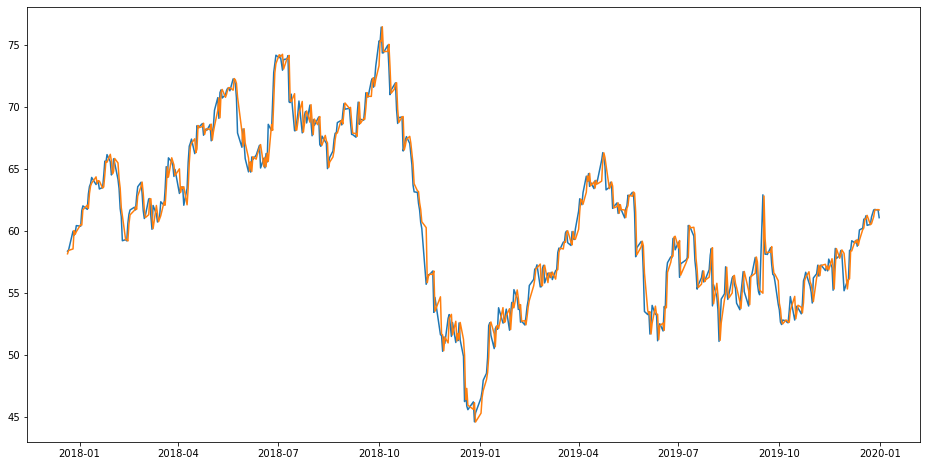

r2(pred):  0.9677636777472222
MSPE: 1.3854776867181018
MDA:  0.5270541082164328
Theil's U2 (Accuracy):  0.9971835122050965


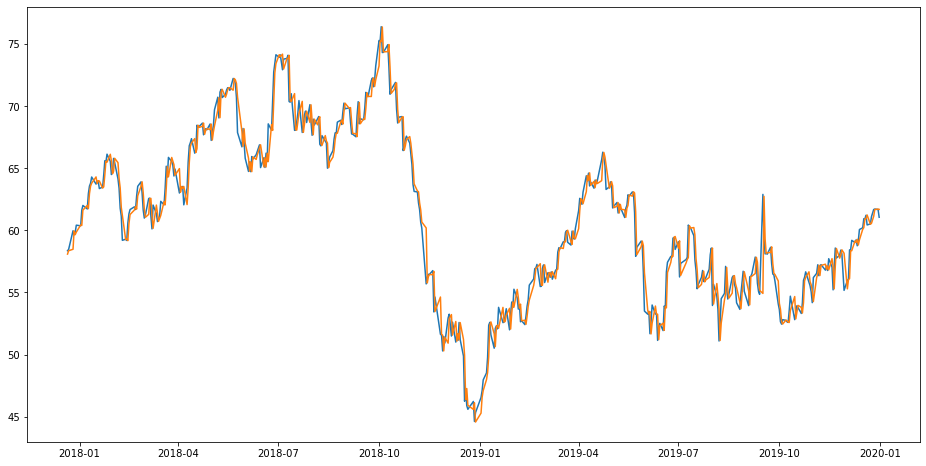

r2(pred):  0.9674786579017989
MSPE: 1.397727490929929
MDA:  0.5490981963927856
Theil's U2 (Accuracy):  1.0016183865187216


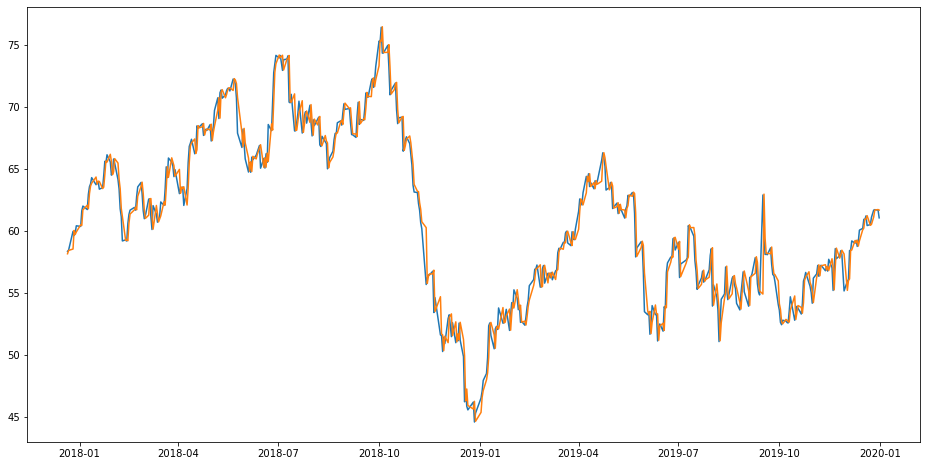

In [11]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'growing')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'growing')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'growing')

# Recursive Feature Elimination

In [12]:
def rfe(X, y):
    trainX = X[:-400]
    trainy = y[:-400]
    valX = X[-400:]
    valy = y[-400:]
    lr = LinearRegression().fit(trainX, trainy)
    score = lr.score(valX, valy)
    features = trainX.columns
    
    for i in range(len(trainX)-1):
        selector = RFE(LinearRegression(), n_features_to_select = i+1).fit(trainX,trainy)
        new_score = selector.score(valX, valy)
        if new_score > score:
            score = new_score
            features = selector.get_feature_names_out()

    return features

All variables

In [13]:
selected = rfe(trainX, trainy)
print(selected)

['Price' 'EMA(12)' 'EMA(26)' 'MACD' '%K(14)' '%R(14)']


Technical Only

In [14]:
X_2 = X.drop(columns=['Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production'])
trainX_2 = X_2[:-500]
selected_2 = rfe(trainX_2, trainy)
print(selected_2)

['Price' 'EMA(5)' 'EMA(12)' 'EMA(26)' 'MACD' '%K(14)' '%R(14)']


Macroeconomic Only

In [15]:
X_3 = X[['Price','Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production']]
trainX_3 = X_3[:-500]
selected_3 = rfe(trainX_3, trainy)
print(selected_3)

['Price']


## Out of sample forecasting with moving window method

r2(pred):  0.9676744943368469
MSPE: 1.3893106805730286
MDA:  0.5170340681362725
Theil's U2 (Accuracy):  0.998496907092746


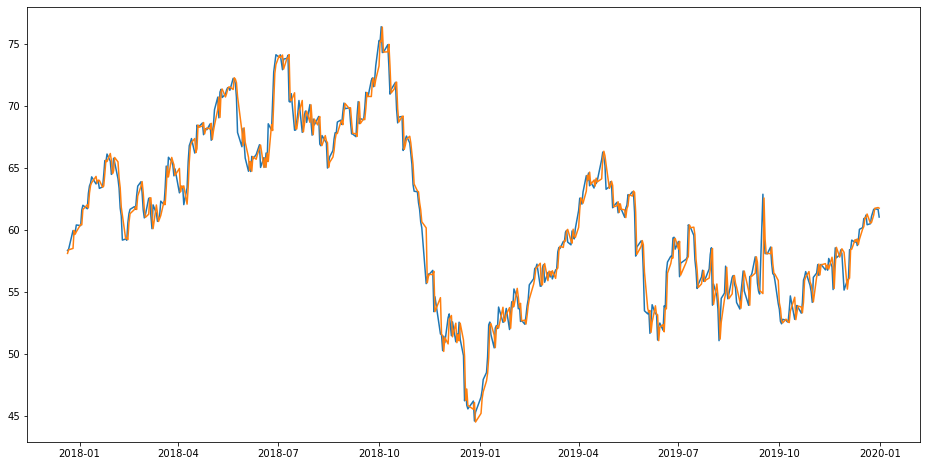

r2(pred):  0.9677702996149808
MSPE: 1.3851930869442157
MDA:  0.5150300601202404
Theil's U2 (Accuracy):  0.9970238959198919


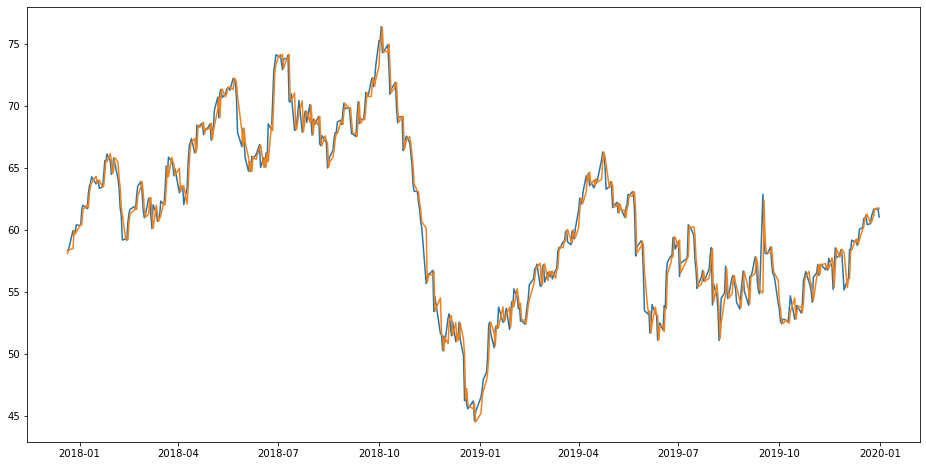

r2(pred):  0.9676152582410922
MSPE: 1.3918565754884926
MDA:  0.5450901803607214
Theil's U2 (Accuracy):  0.9995006875228287


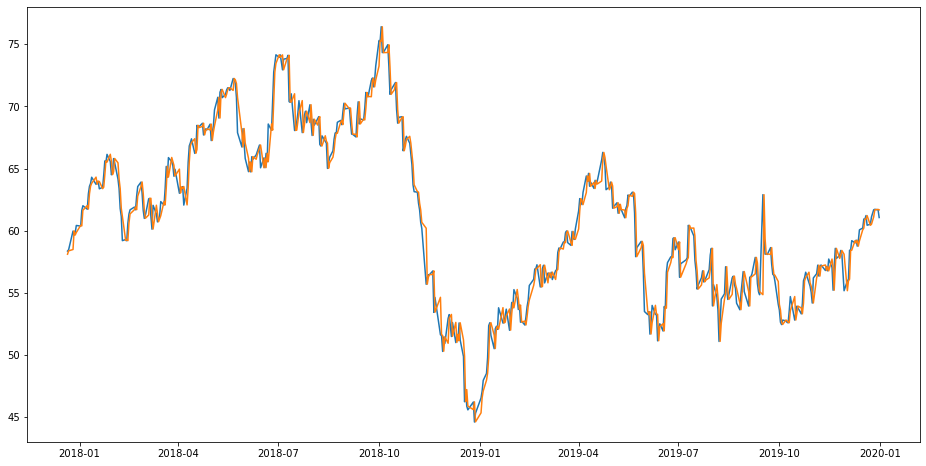

In [16]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'moving')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'moving')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'moving')

## Out of sample forecasting with growing window method

r2(pred):  0.9676116920084638
MSPE: 1.3920098478032918
MDA:  0.5230460921843687
Theil's U2 (Accuracy):  0.999500557046921


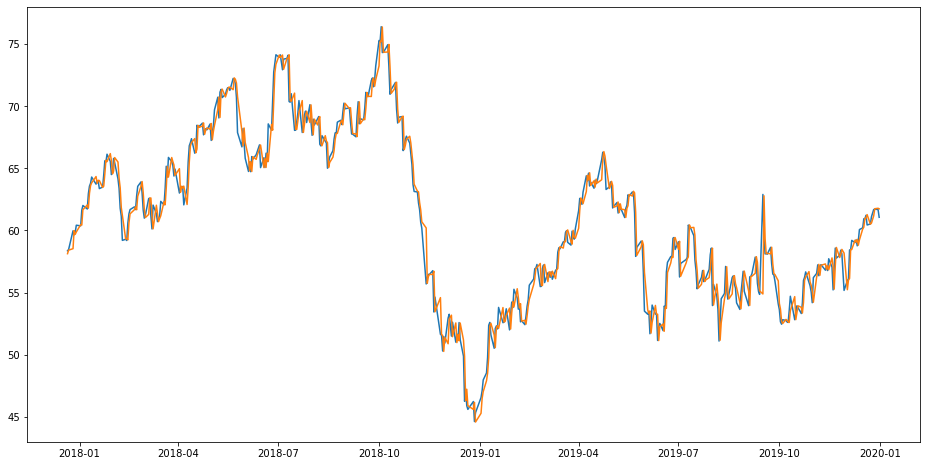

r2(pred):  0.967685585349676
MSPE: 1.3888340024123758
MDA:  0.5210420841683366
Theil's U2 (Accuracy):  0.9983605104511241


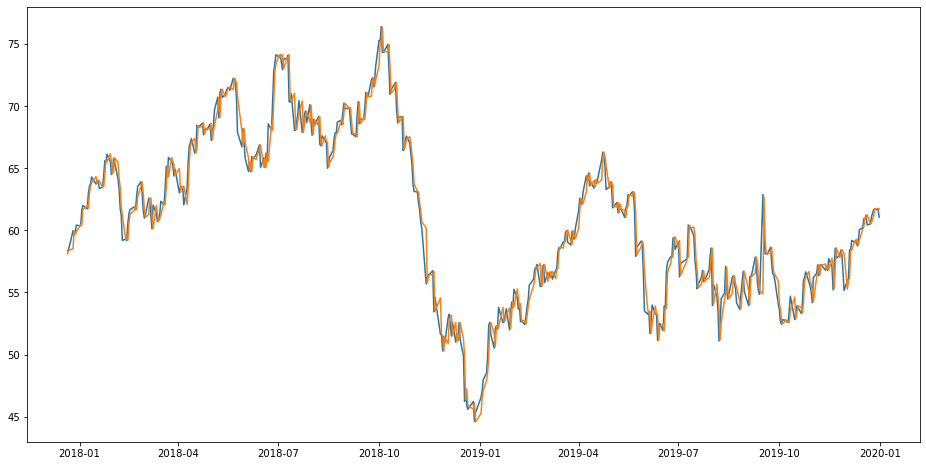

r2(pred):  0.9676127410469786
MSPE: 1.391964761411507
MDA:  0.5531062124248497
Theil's U2 (Accuracy):  0.9995218518412914


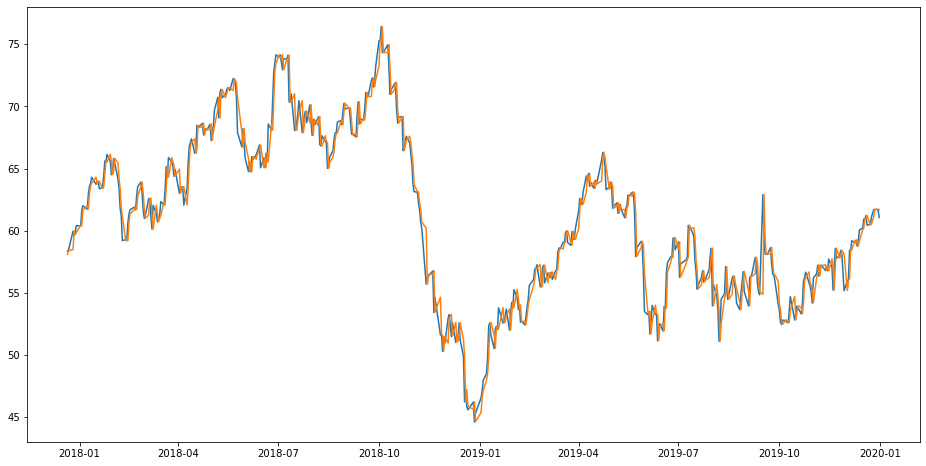

In [17]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'growing')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'growing')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'growing')

# Genetic Algorithm

In [18]:
def genetic(X, y):
    estimators = LinearRegression()
    cv = TimeSeriesSplit(n_splits=2)
    selectors = GeneticSelectionCV(estimators,
                                  scoring="r2",
                                  cv=cv,
                                  n_gen_no_change=20,
                                  n_jobs=-1)
    selectors.fit(X,y)
    result = selectors.support_
    selected = X.columns[result]
    return selected

## Get the list of feature subset selected by the genetic algorithm

In [19]:
selected = genetic(trainX, trainy)
print(selected)

Index(['Price', 'USDX', 'Vol.', 'MA(10)', 'EMA(5)', 'RSI(14)', 'CCI(14)'], dtype='object')


Technical Indicators Only

In [20]:
X_2 = X.drop(columns=['Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production'])
trainX_2 = X_2[:-500]
selected_2 = genetic(trainX_2, trainy)
print(selected_2)

Index(['Price', 'Vol.', 'MA(5)', 'MA(20)', 'RSI(14)', 'ATR(14)', 'CCI(14)'], dtype='object')


Macroeconomic Variables Only

In [21]:
X_3 = X[['Price','Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production']]
trainX_3 = X_3[:-500]
selected_3 = genetic(trainX_3, trainy)
print(selected_3)

Index(['Price', 'USDX'], dtype='object')


## Out of sample forecasting with moving window method

r2(pred):  0.9680547363155768
MSPE: 1.3729683455835462
MDA:  0.48697394789579157
Theil's U2 (Accuracy):  0.9927206801409207


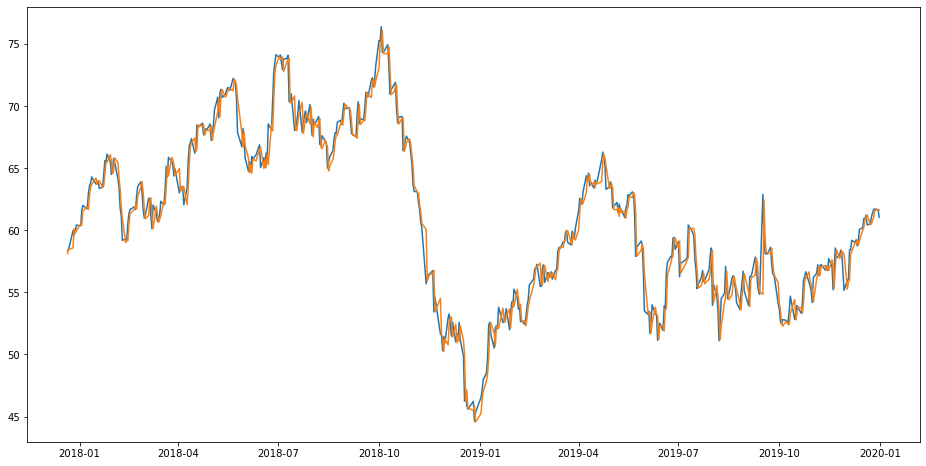

r2(pred):  0.9677950463593832
MSPE: 1.3841295021494155
MDA:  0.5150300601202404
Theil's U2 (Accuracy):  0.9966735617807806


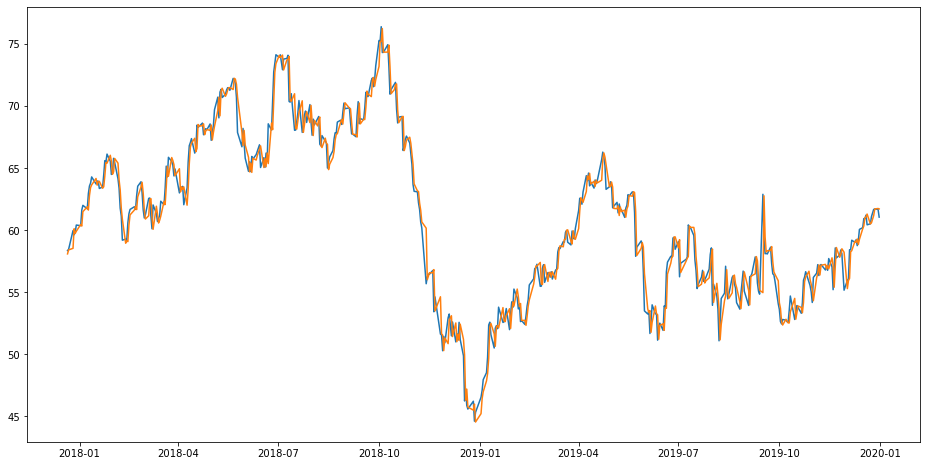

r2(pred):  0.9677932812772367
MSPE: 1.3842053632203515
MDA:  0.4709418837675351
Theil's U2 (Accuracy):  0.9968089712190279


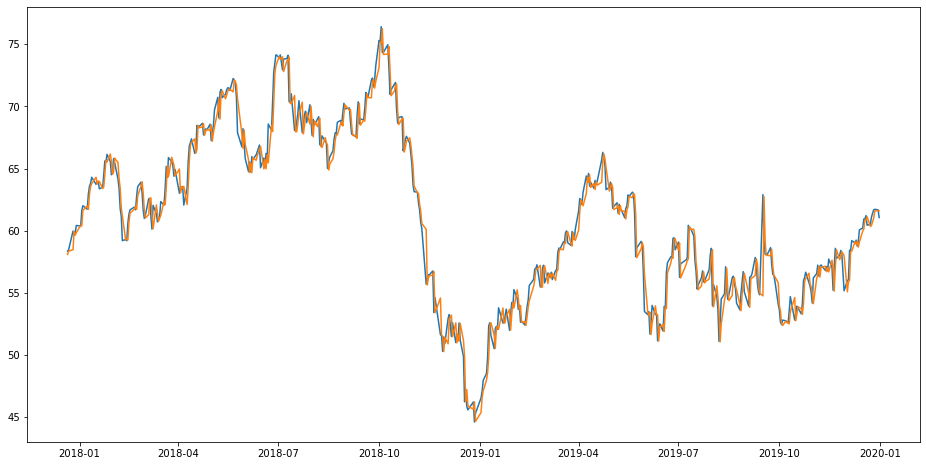

In [22]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'moving')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'moving')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'moving')

## Out of sample forecasting with growing window method

r2(pred):  0.9679376692434517
MSPE: 1.3779997451026016
MDA:  0.4709418837675351
Theil's U2 (Accuracy):  0.9945675473310456


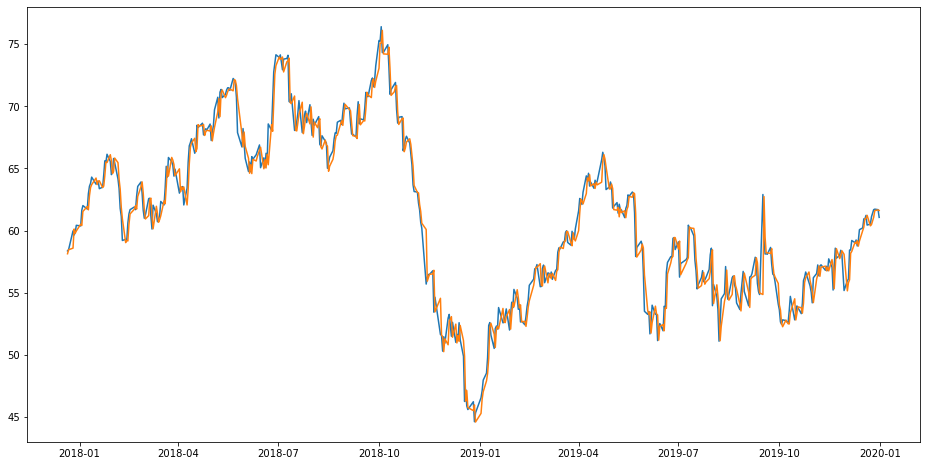

r2(pred):  0.9676207479303223
MSPE: 1.391620635362453
MDA:  0.5290581162324649
Theil's U2 (Accuracy):  0.9994033105998513


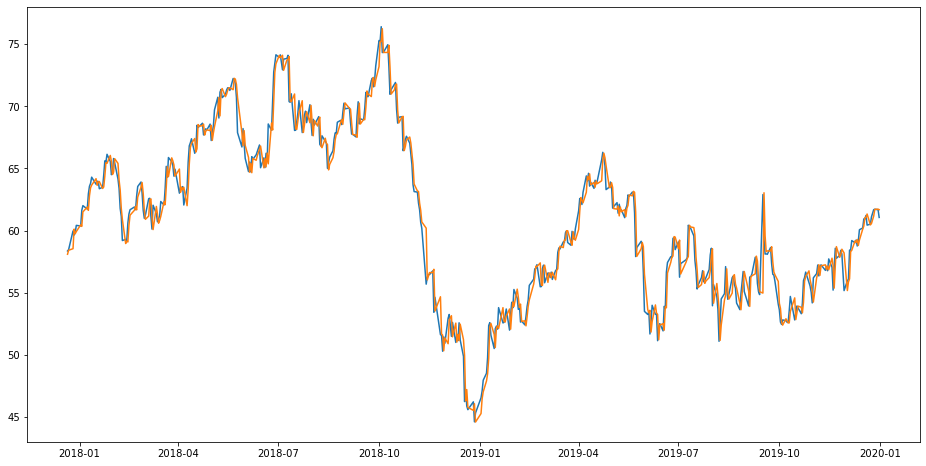

r2(pred):  0.9678098805564982
MSPE: 1.3834919465082358
MDA:  0.46893787575150303
Theil's U2 (Accuracy):  0.9965535691091011


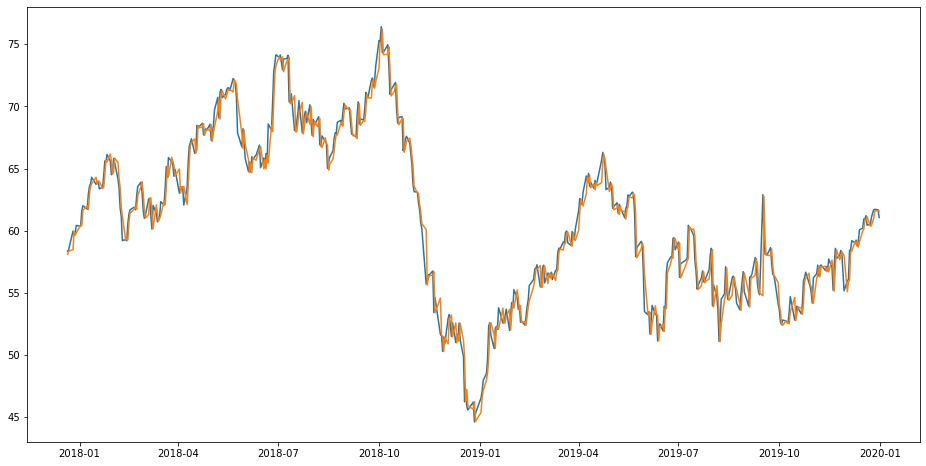

In [23]:
a = forecast(trainX[selected], trainy, testX[selected], testy, 'growing')
t = forecast(trainX[selected_2], trainy, testX[selected_2], testy, 'growing')
m = forecast(trainX[selected_3], trainy, testX[selected_3], testy, 'growing')

# Lasso Regression

In [24]:
def lasso(X, y):
    features = X.columns
    X = np.asarray(X)
    y = np.asarray(y)

    sc= MinMaxScaler()
    X = sc.fit_transform(X)
    sc_y = MinMaxScaler()
    y = sc_y.fit_transform(y.reshape(-1,1))
    
    
    cv = TimeSeriesSplit(n_splits=2, test_size=200)
    lasso = LassoCV(alphas=np.arange(0.0001,0.001, 0.0001), cv = cv, max_iter=100000000).fit(X, y.reshape(-1,))
    
    selected = features[np.abs(lasso.coef_) > 0]
    alpha = lasso.alpha_
    return selected, alpha

def forecasting_lasso(trainX, trainy, testX, testy, method, alpha):
    testX = np.asarray(testX)
    testy = np.asarray(testy)
    historyX = np.asarray(trainX)
    historyY = np.asarray(trainy)
    
    count = []
    prediction = list()
    for i in range(len(testy)):
        
        #normalize X
        sc = MinMaxScaler()
        trainX_scaled = sc.fit_transform(historyX)
        testX_scaled = sc.transform(testX)

        #normalize y
        sc_y = MinMaxScaler()
        trainy_scaled = sc_y.fit_transform(historyY.reshape(-1,1))
        
        #predict the next target value
        model = Lasso(alpha=alpha, max_iter=100000000).fit(trainX_scaled, trainy_scaled.reshape(-1,))
        count.append(np.count_nonzero([np.abs(model.coef_) > 0]))
        y_pred = sc_y.inverse_transform(model.predict(testX_scaled[i].reshape(1,-1)).reshape(1,-1))[0][0]
        
        prediction.append(y_pred)
        
        if method == 'moving':
            historyX = np.append(historyX[1:], testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY[1:], testy[i])
        elif method == "growing":
            historyX = np.append(historyX, testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY, testy[i])
        
    return prediction, count

def forecast_lasso(trainX, trainy, testX, testy, method, alpha):
    p, c = forecasting_lasso(trainX, trainy, testX, testy, method, alpha)
    mspe = mean_squared_error(testy, p)
    r2 = r2_score(testy, p)
    print("r2(pred): ", r2)
    print("MSPE:", mspe)
    print("MDA: ", TheilU(p, testy.values)[0])
    print("Theil's U2 (Accuracy): ", TheilU(p, testy.values)[1])
    plt.figure(figsize=(16,8))
    plt.plot(df['Date'][-500:], testy)
    plt.plot(df['Date'][-500:], p)
    plt.show()
    plt.figure(figsize=(16,8))
    plt.plot(df['Date'][-500:], c)
    plt.show()
    return mspe, r2

## Get the list of feature subset selected by the Lasso Regression

In [25]:
selected, alpha = lasso(trainX, trainy)
print(selected, alpha)

Index(['Price', 'Heating Oil', 'USDX', 'World Production',
       'US Field Production', 'Refinery', 'MA(5)', 'MA(12)', 'EMA(12)',
       'ADX(14)'],
      dtype='object') 0.0001


Technical Indicators Only

In [26]:
X_2 = X.drop(columns=['Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production'])
trainX_2 = X_2[:-500]
selected_2, alpha_2 = lasso(trainX_2, trainy)
print(selected_2, alpha_2)

Index(['Price', 'MA(5)', 'MA(12)', 'MA(20)', 'EMA(12)', 'ATR(14)', 'ADX(14)'], dtype='object') 0.0001


Macroeconomic Variables Only

In [27]:
X_3 = X[['Price','Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production']]
trainX_3 = X_3[:-500]
selected_3, alpha_3 = lasso(trainX_3, trainy)
print(selected_3, alpha_3)

Index(['Price', 'Heating Oil', 'USDX', 'Refinery', 'US Field Production',
       'World Production'],
      dtype='object') 0.0001


## Out of sample forecasting with moving window method

r2(pred):  0.9678124408219848
MSPE: 1.3833819094303066
MDA:  0.48096192384769537
Theil's U2 (Accuracy):  0.9964474873442215


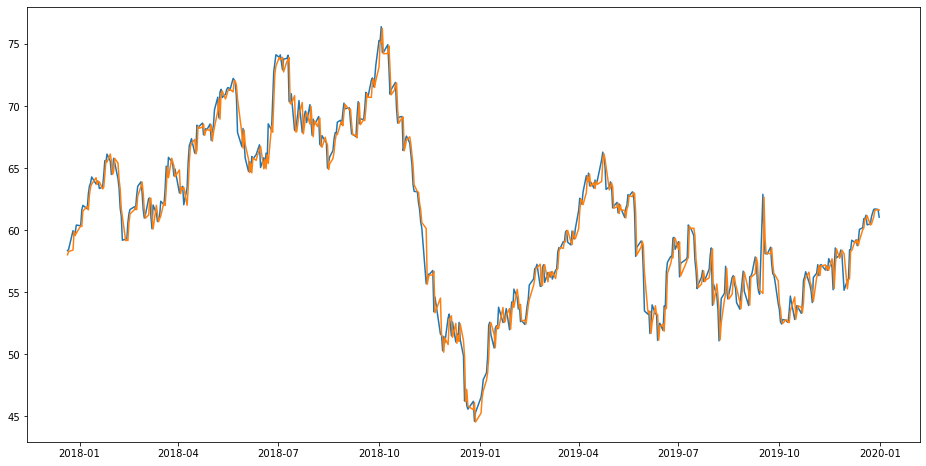

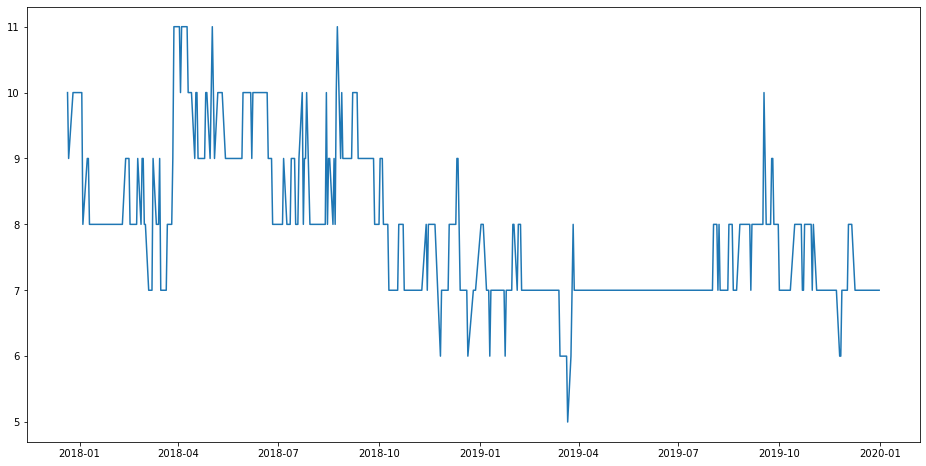

r2(pred):  0.9677641061082338
MSPE: 1.3854592762859541
MDA:  0.5450901803607214
Theil's U2 (Accuracy):  0.9971701034089225


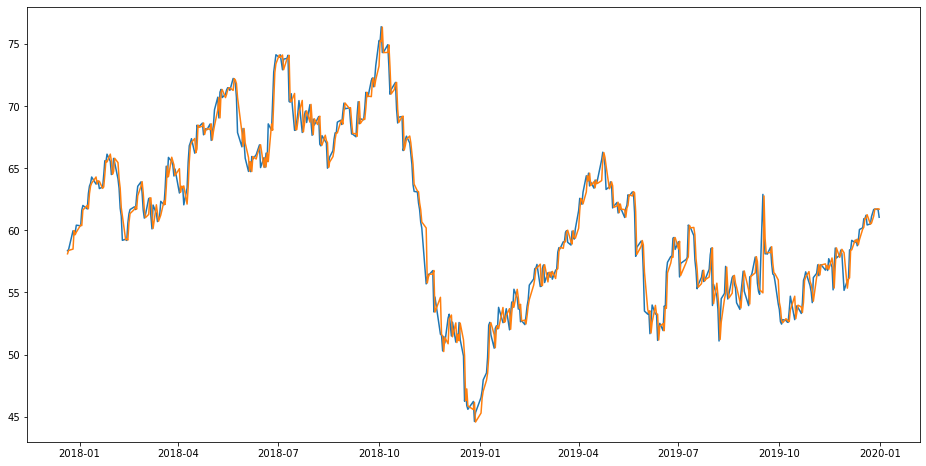

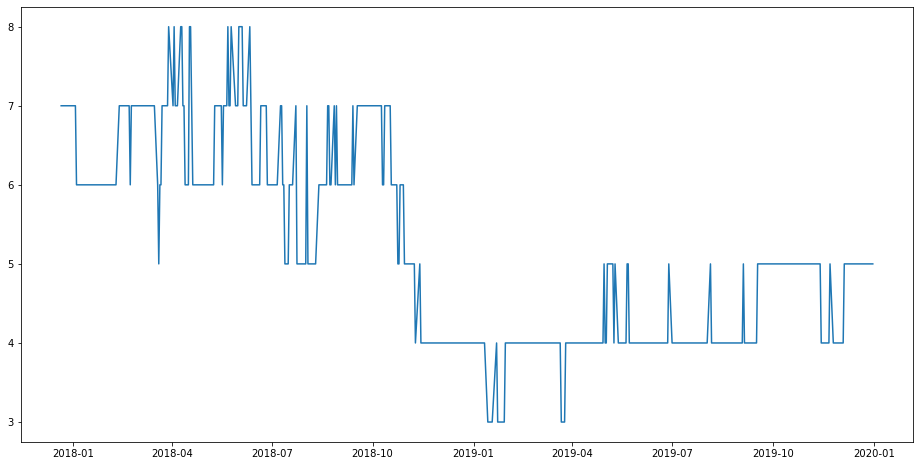

r2(pred):  0.9675654829494602
MSPE: 1.3939958566188022
MDA:  0.4909819639278557
Theil's U2 (Accuracy):  1.0002721217266772


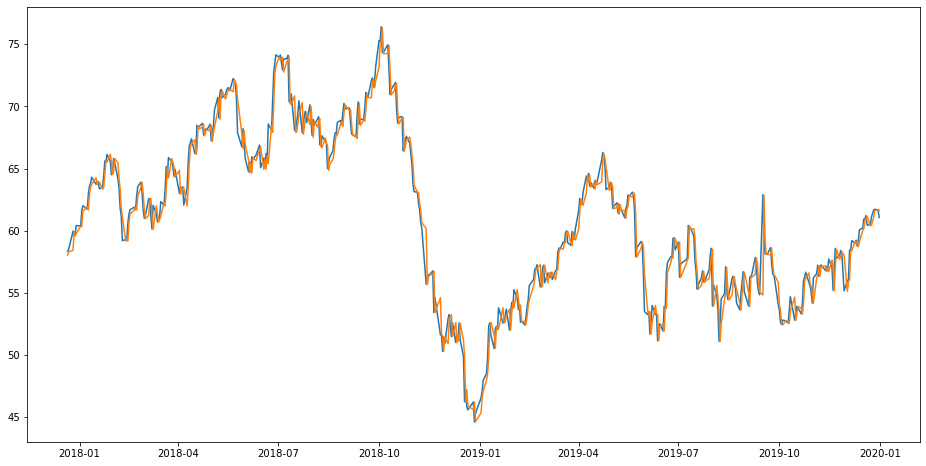

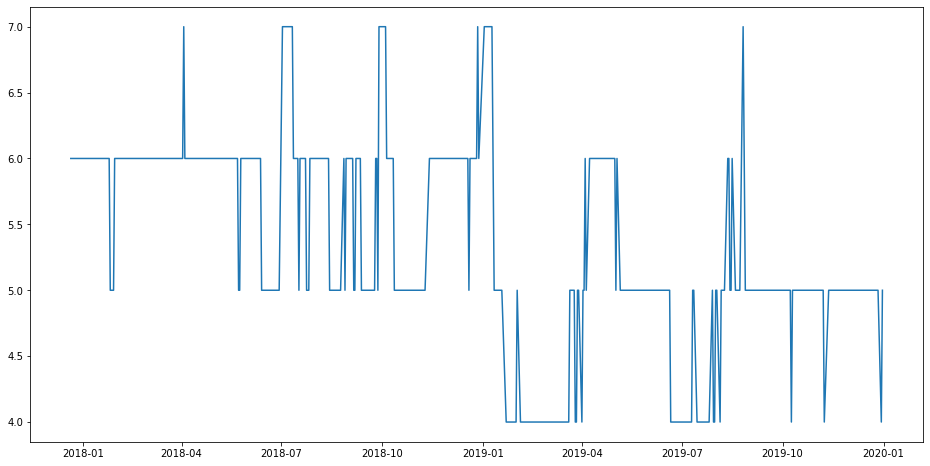

In [28]:
testX_2 = X_2[-500:]
testX_3 = X_3[-500:]
a = forecast_lasso(trainX, trainy, testX, testy, 'moving', alpha)
t = forecast_lasso(trainX_2, trainy, testX_2, testy, 'moving', alpha_2)
m = forecast_lasso(trainX_3, trainy, testX_3, testy, 'moving', alpha_3)

## Out of sample forecasting with growing window method

r2(pred):  0.9677257506726984
MSPE: 1.3871077459743415
MDA:  0.48296593186372744
Theil's U2 (Accuracy):  0.9978102609067977


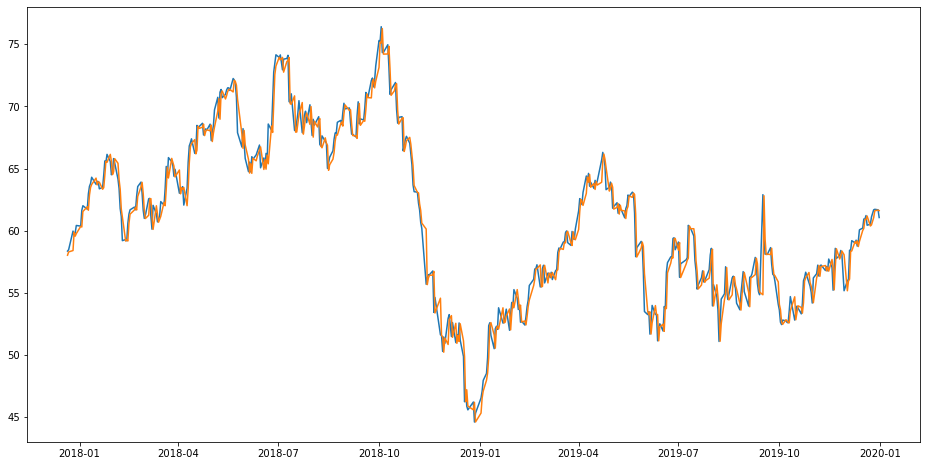

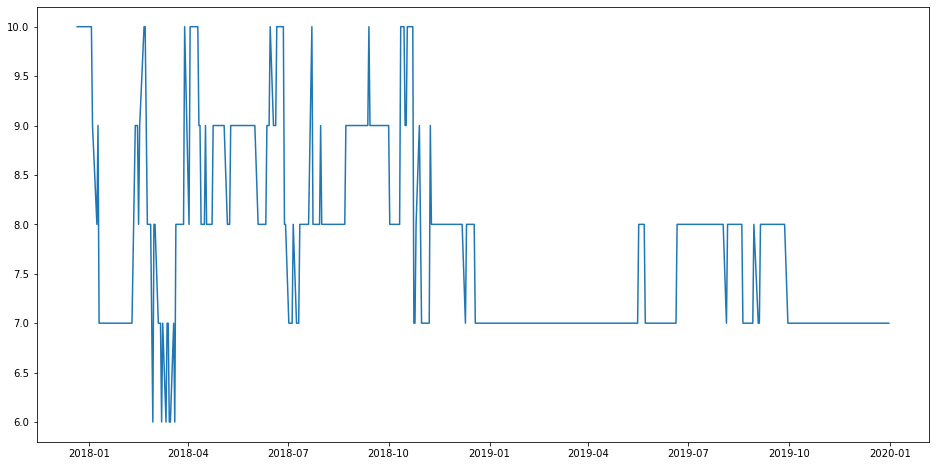

r2(pred):  0.9676401290663219
MSPE: 1.3907876578515534
MDA:  0.5470941883767535
Theil's U2 (Accuracy):  0.9990861882047863


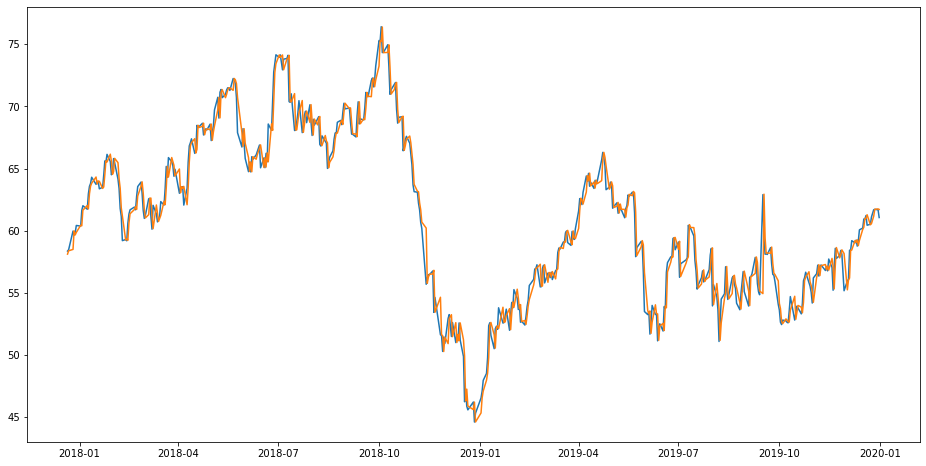

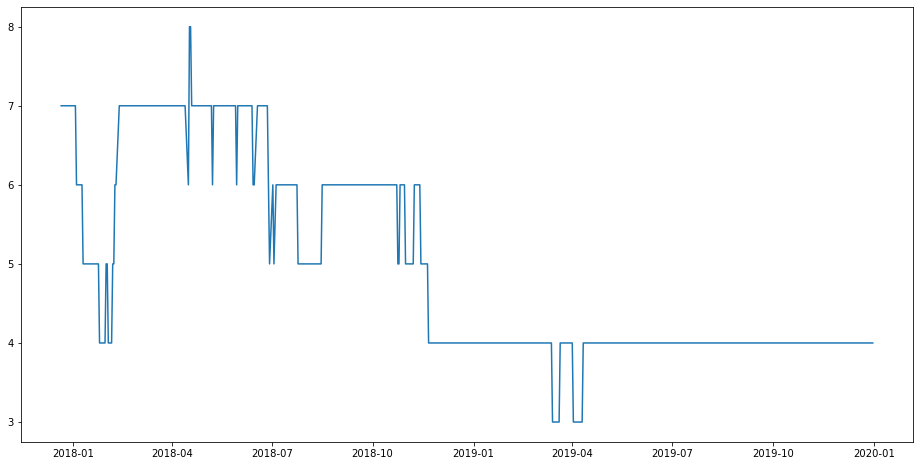

r2(pred):  0.967687687550941
MSPE: 1.3887436523742125
MDA:  0.48697394789579157
Theil's U2 (Accuracy):  0.9984067210922892


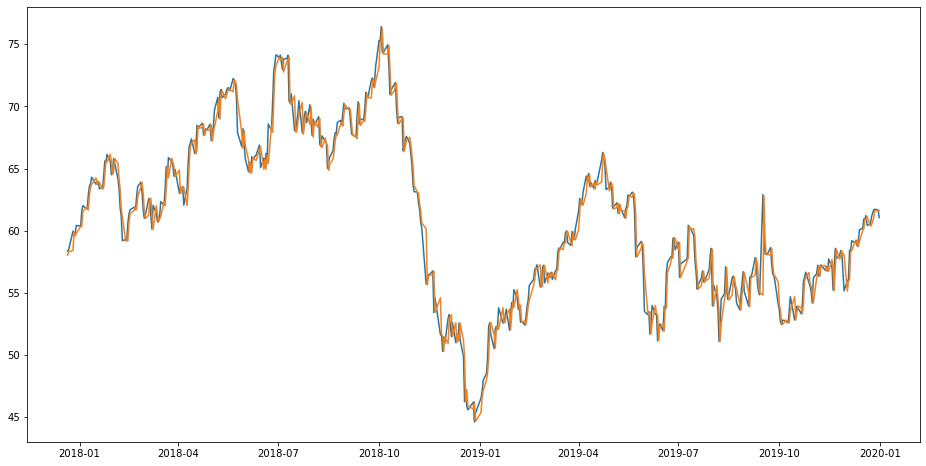

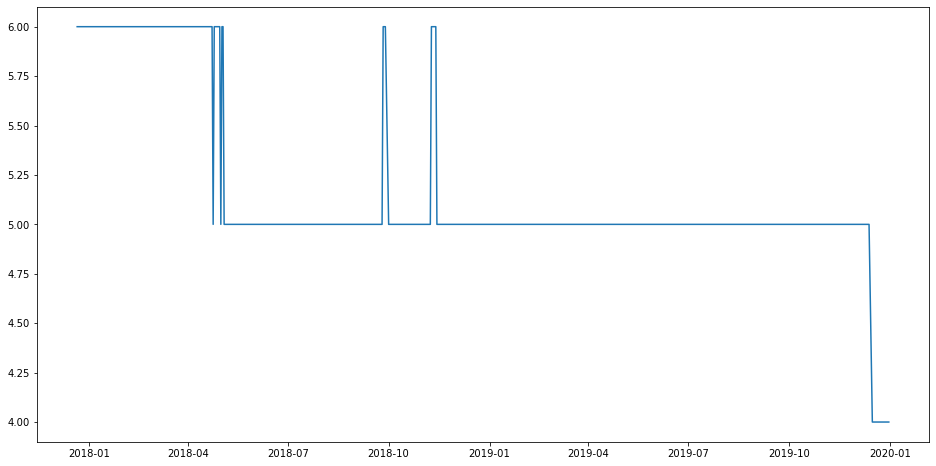

In [29]:
a = forecast_lasso(trainX, trainy, testX, testy, 'growing', alpha)
t = forecast_lasso(trainX_2, trainy, testX_2, testy, 'growing', alpha_2)
m = forecast_lasso(trainX_3, trainy, testX_3, testy, 'growing', alpha_3)

# Elastic Net Regression

In [30]:
def elastic(X, y):
    features = X.columns
    X = np.asarray(X)
    y = np.asarray(y)

    sc= MinMaxScaler()
    X = sc.fit_transform(X)
    sc_y = MinMaxScaler()
    y = sc_y.fit_transform(y.reshape(-1,1))
    
    
    cv = TimeSeriesSplit(n_splits=2, test_size=200)
    en = ElasticNetCV(alphas=np.arange(0.0001, 0.001, 0.0001), l1_ratio = np.arange(0.001, 1, 0.001), cv = cv, max_iter=100000000).fit(X, y.reshape(-1,))
    
    selected = features[np.abs(en.coef_) > 0]
    alpha = en.alpha_
    ratio = en.l1_ratio_
    return selected, alpha, ratio

def forecasting_en(trainX, trainy, testX, testy, method, alpha, ratio):
    testX = np.asarray(testX)
    testy = np.asarray(testy)
    historyX = np.asarray(trainX)
    historyY = np.asarray(trainy)
    
    count = []
    prediction = list()
    for i in range(len(testy)):
        

        #normalize X
        sc = MinMaxScaler()
        trainX_scaled = sc.fit_transform(historyX)
        testX_scaled = sc.transform(testX)

        #normalize y
        sc_y = MinMaxScaler()
        trainy_scaled = sc_y.fit_transform(historyY.reshape(-1,1))
        
        #predict the next target value
        model = ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=100000000).fit(trainX_scaled, trainy_scaled.reshape(-1,))
        count.append(np.count_nonzero([np.abs(model.coef_) > 0]))
        y_pred = sc_y.inverse_transform(model.predict(testX_scaled[i].reshape(1,-1)).reshape(1,-1))[0][0]

        prediction.append(y_pred)
        
        if method == 'moving':
            historyX = np.append(historyX[1:], testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY[1:], testy[i])
        elif method == "growing":
            historyX = np.append(historyX, testX[i].reshape(1,-1), axis=0)
            historyY = np.append(historyY, testy[i])
        
    return prediction, count

def forecast_en(trainX, trainy, testX, testy, method, alpha, ratio):
    p,c = forecasting_en(trainX, trainy, testX, testy, method, alpha, ratio)
    mspe = mean_squared_error(testy, p)
    r2 = r2_score(testy, p)
    print("r2(pred): ", r2)
    print("MSPE:", mspe)
    print("MDA: ", TheilU(p, testy.values)[0])
    print("Theil's U2 (Accuracy): ", TheilU(p, testy.values)[1])
    plt.figure(figsize=(16,8))
    plt.plot(df['Date'][-500:], testy)
    plt.plot(df['Date'][-500:], p)
    plt.show()
    plt.figure(figsize=(16,8))
    plt.plot(df['Date'][-500:], c)
    plt.show()
    return mspe, r2

## Get the list of feature subset selected by Elastic Net Regression

In [31]:
selected, alpha, ratio = elastic(trainX, trainy)
print(selected)
print(alpha, ratio)

Index(['Price', 'Heating Oil', 'USDX', 'World Production',
       'US Field Production', 'Refinery', 'Vol.', 'MA(5)', 'MA(20)', 'EMA(5)',
       'ADX(14)', 'Aroon(25)', 'CCI(14)'],
      dtype='object')
0.0001 0.866


Technical Indicators Only

In [32]:
X_2 = X.drop(columns=['Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production'])
trainX_2 = X_2[:-500]
selected_2, alpha_2, ratio_2 = elastic(trainX_2, trainy)
print(selected_2)
print(alpha_2, ratio_2)

Index(['Price', 'Vol.', 'MA(5)', 'MA(12)', 'MA(20)', 'EMA(5)', '%K(14)',
       'ATR(14)', 'ADX(14)', 'Aroon(25)', '%R(14)', 'CCI(14)'],
      dtype='object')
0.0001 0.8260000000000001


Macroeconomic Variables Only

In [33]:
X_3 = X[['Price','Gold','Heating Oil','Natural Gas','EFFR','Treasury Bill','USDX','MSCI','CRBI','XOI',"Refinery",'CFNAI','INDPRO','Kilian','Unemployment','TCU','US Field Production','World Production']]
trainX_3 = X_3[:-500]
selected_3, alpha_3, ratio_3 = elastic(trainX_3, trainy)
print(selected_3)
print(alpha_3, ratio_3)

Index(['Price', 'Heating Oil', 'USDX', 'Refinery', 'US Field Production',
       'World Production'],
      dtype='object')
0.0002 0.719


## Out of sample forecasting with moving window method

r2(pred):  0.9679435969321067
MSPE: 1.3777449802972077
MDA:  0.5150300601202404
Theil's U2 (Accuracy):  0.9943547697206798


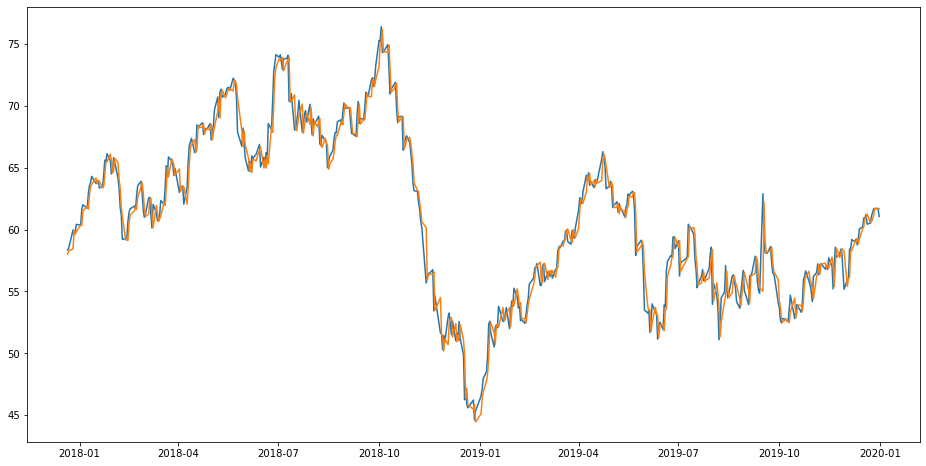

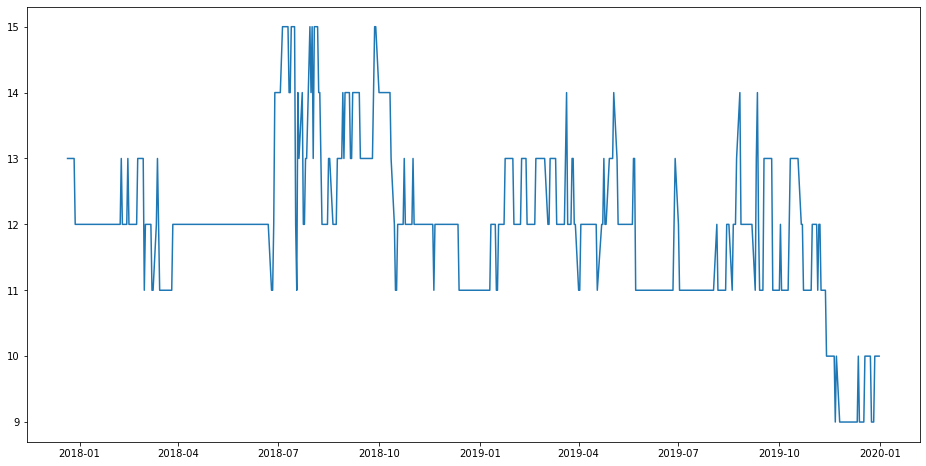

r2(pred):  0.9679419576373428
MSPE: 1.3778154351803533
MDA:  0.5250501002004008
Theil's U2 (Accuracy):  0.9943131803121792


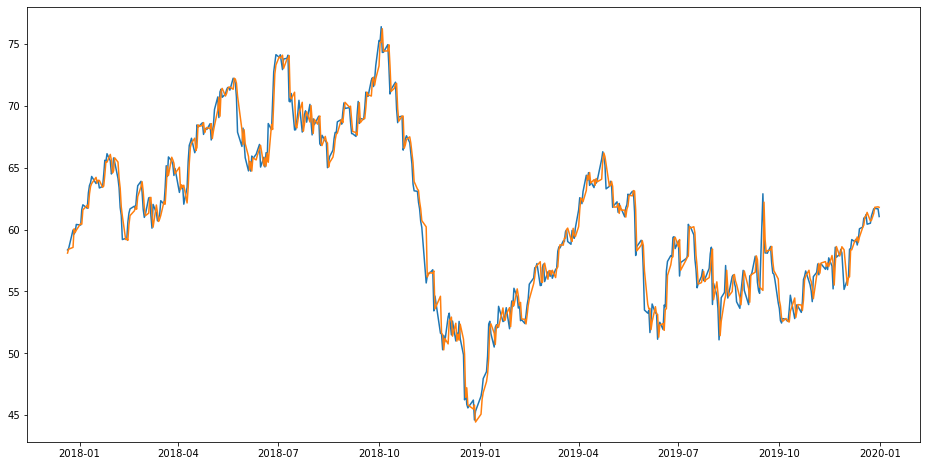

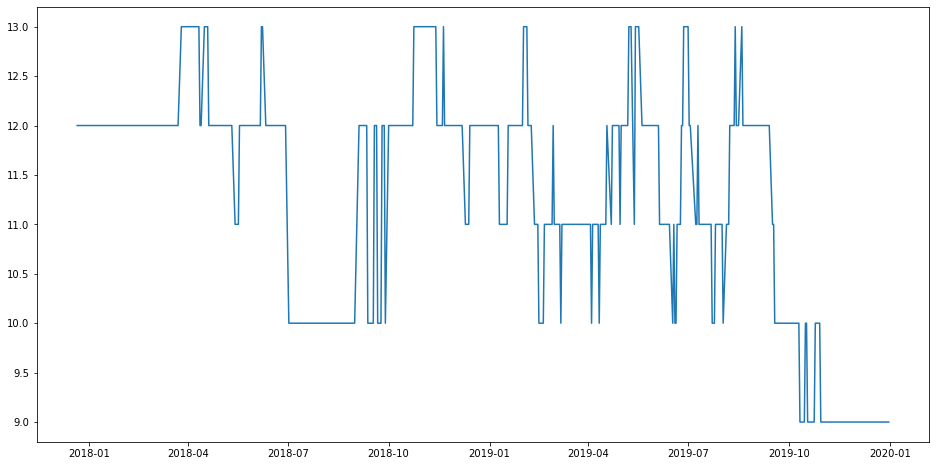

r2(pred):  0.9674973898185157
MSPE: 1.3969224160694294
MDA:  0.49298597194388777
Theil's U2 (Accuracy):  1.001368271374548


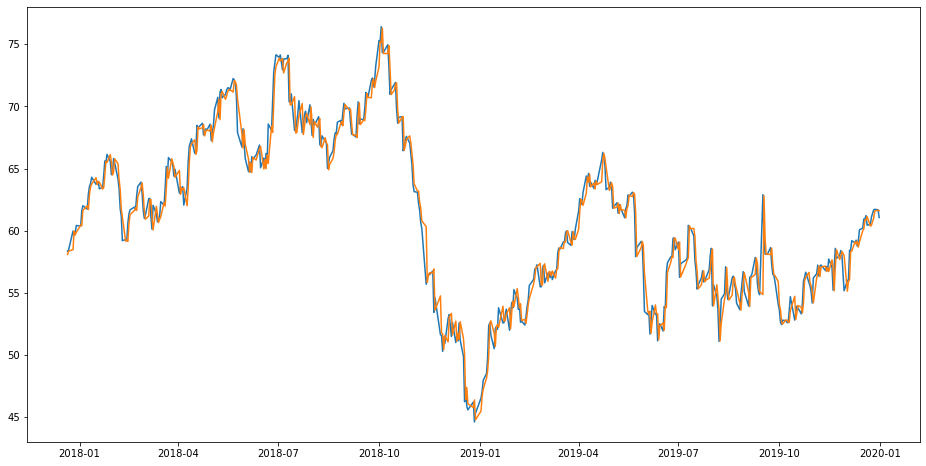

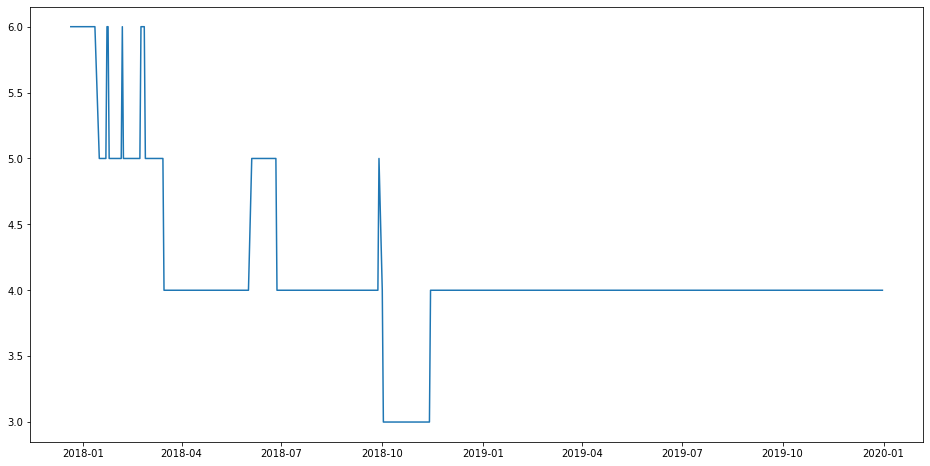

In [34]:
testX_2 = X_2[-500:]
testX_3 = X_3[-500:]
a = forecast_en(trainX, trainy, testX, testy, 'moving', alpha, ratio)
t = forecast_en(trainX_2, trainy, testX_2, testy, 'moving', alpha_2, ratio_2)
m = forecast_en(trainX_3, trainy, testX_3, testy, 'moving', alpha_3, ratio_3)

## Out of sample forecasting with growing window method

r2(pred):  0.9678399936986716
MSPE: 1.3821977205034501
MDA:  0.49899799599198397
Theil's U2 (Accuracy):  0.9960022678714402


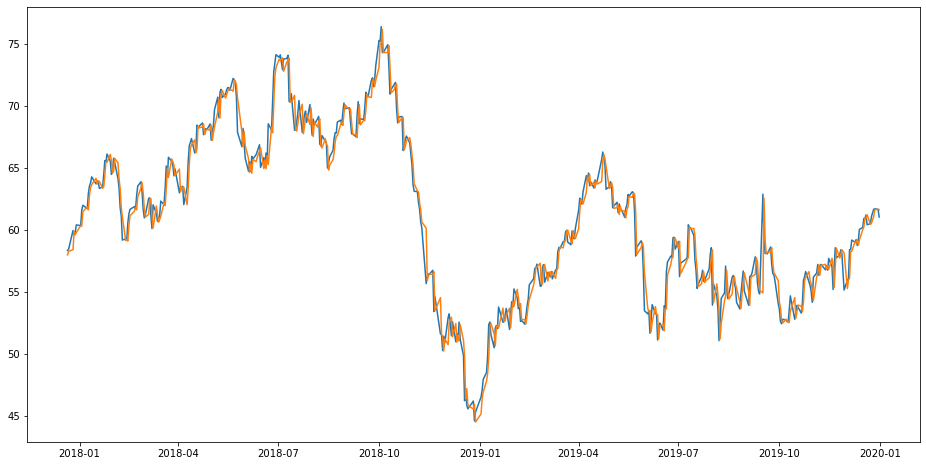

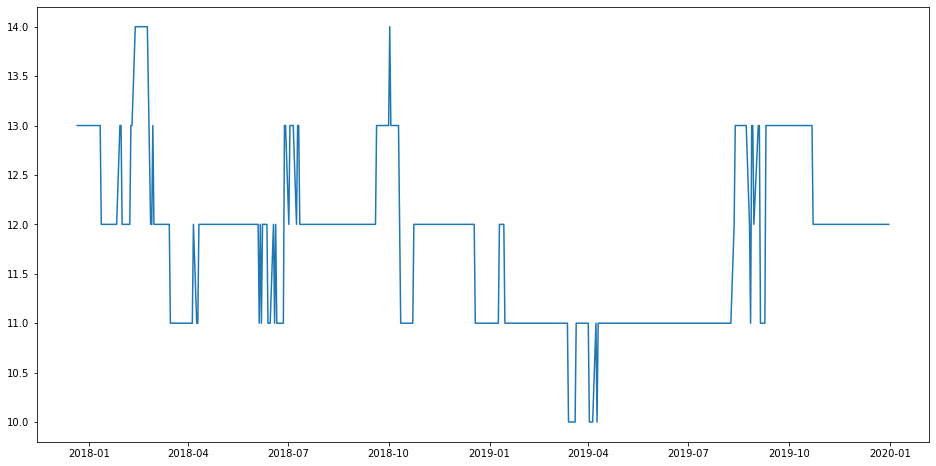

r2(pred):  0.9678038838634349
MSPE: 1.3837496770386668
MDA:  0.531062124248497
Theil's U2 (Accuracy):  0.9964808974778961


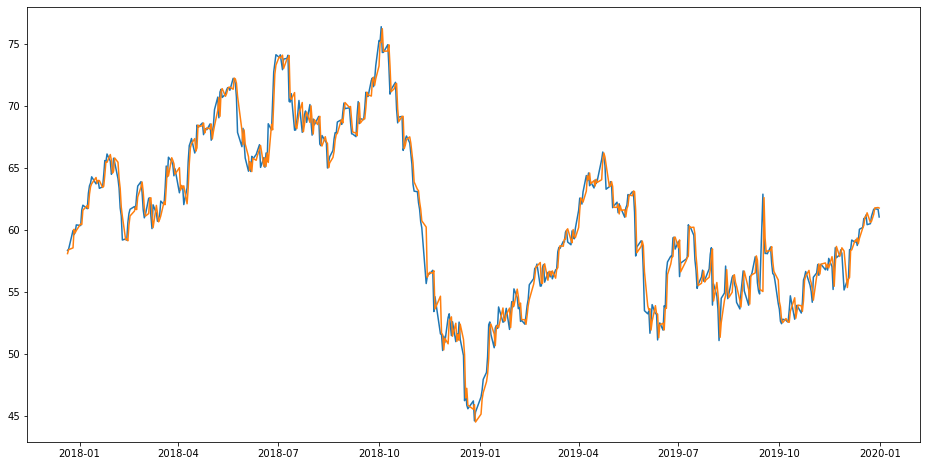

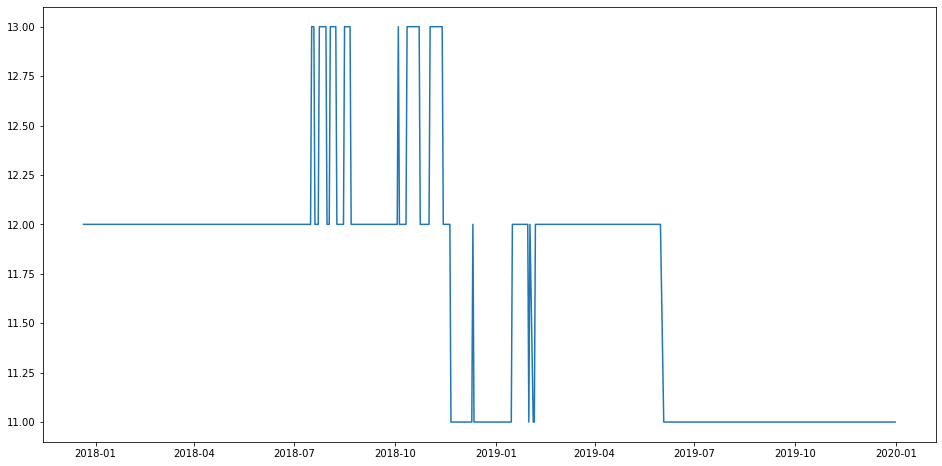

r2(pred):  0.9676974601469005
MSPE: 1.3883236381574249
MDA:  0.4969939879759519
Theil's U2 (Accuracy):  0.9982813771692103


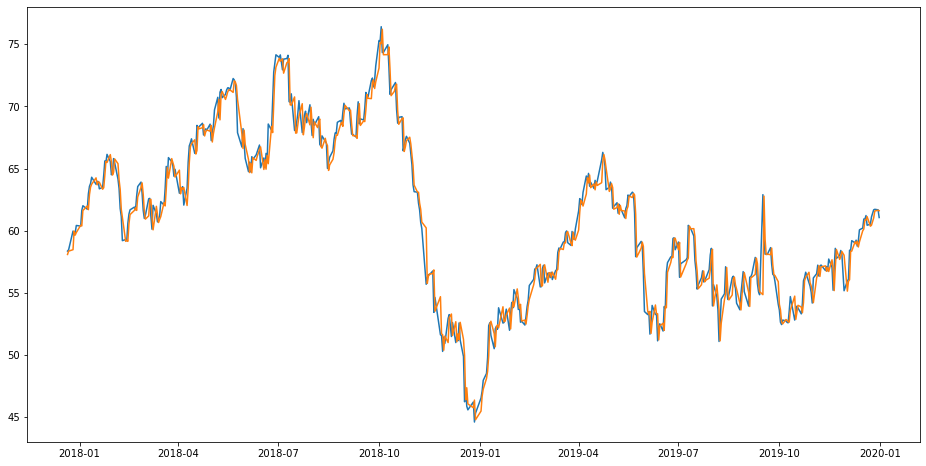

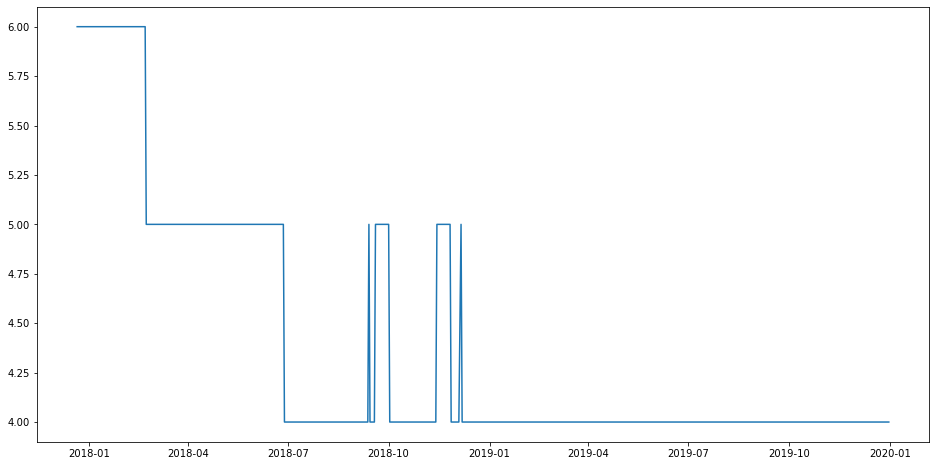

In [35]:
a = forecast_en(trainX, trainy, testX, testy, 'growing', alpha, ratio)
t = forecast_en(trainX_2, trainy, testX_2, testy, 'growing', alpha_2, ratio_2)
m = forecast_en(trainX_3, trainy, testX_3, testy, 'growing', alpha_3, ratio_3)